In [1]:
#libraries to create patch from images to and read ini files
import cv2
import os
import configparser

In [2]:
#libraries to create model, train and test
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras.backend as K
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow import keras

Using TensorFlow backend.
/Users/nisan.coskun/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nisan.coskun/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nisan.coskun/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nisan.coskun/anaconda3/lib/p

In [3]:
#initialize config parser to retrieve cell center in ini files
config = configparser.ConfigParser()

#array of directory names
scores = ['Score_0', 'Score_1', 'Score_2', 'Score_3']

# This function creates array that consist of image's relative paths according to folder name

In [4]:
def imgname_from_folder(folder_name):
    images = []
    for filename in os.listdir(folder_name):
        if filename.endswith('.jpg'):
            img = os.path.join(filename)
            image_name = os.path.splitext(img)
            images.append(image_name[0])
    return images

# The intent of the function below is to generate images and so that provides image augmentation to train model better

dataset: folder name that consist of cell patches (example: 'Score_0_cells')

img_name: image name (example: 'MultiShoot2 (17).jpg')

count: the number of how many images will be generated

In [5]:
def generate_image(dataset, img_name, count = 5):
    
#ImageDataGenerator is used for generating image
    datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')
    
#generated images are saved in dataset folder
    image_path= dataset + '/'+ img_name 
    img = load_img(image_path)  
    x = img_to_array(img)  
    x = x.reshape((1,) + x.shape)

    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=dataset, save_prefix=img, save_format='jpg'):
        i += 1
        if i > count:
            break  


# crop_image function is to parse image to patches

file_name: image name

path: destination path for writing images

In [6]:
def crop_image(file_name, folder_name, path):
    
    image_path = os.path.join(folder_name,file_name)+'.jpg'
    ini_path = os.path.join(folder_name+'/Features', file_name)+'.ini'
    
    img = cv2.imread(image_path)
    
    #this part read and parse ini file and then gets the cellCount information in ini files
    config.read(ini_path)
    cellCount = config.get('main', 'CellCount')
    loopCount = int(cellCount) - 1
    
    #width and height of images
    Y_size, X_size = img.shape[:2]
    
    """After finding the cell center in images, if center coordinates are not appropriate for 32x32 patches, 
    these are re-centered according to the upper left and lower right coordinates, with this coordinates, 32x32 
    patches are created with images from each score and new images written on the destination path"""
    
    for i in range(loopCount):
        x = int(config.get(str(i), 'CellCenter '+ str(i)+' X' ))
        y = int(config.get(str(i), 'CellCenter '+ str(i)+' Y' ))
        x1, x2, y1, y2 = 0, 0, 0, 0
        if(y < 16):
            y1=0
            y2=32-y
        elif(Y_size-y < 16):
            y1=Y_size-32
            y2=Y_size     
        else:
            y1 = y-16
            y2 = y+16      
        if(x < 32):
            x1=0
            x2=32+x         
        elif(X_size-x < 16):
            x1=X_size-32
            x2=X_size         
        else:
            x1 = x-16
            x2 = x+16
                    
        crop_img = img[y1:y2, x1:x2] 
        img_name = file_name + '_'+ str(i) + '.jpg'
        cv2.imwrite(path+'/'+img_name, crop_img)
        
        #generate_image function is used for image augmentation from these patched images
        generate_image(path, img_name)

# The function below creates new folder for new images, then calls crop_images function and writes new image files on new folder

In [7]:
def patch_image_by_scores(scores):
    for score in scores:
        path = score+"_cells"
        try: 
            os.mkdir(path) 
        except OSError: 
            print ("Creation of the directory %s failed" % path)
        img_names = imgname_from_folder(score)
        for img_name in img_names:
            crop_image(img_name, score, path)

# load_dataset function reads new images and label according to folder name

In [8]:
def load_dataset(): 
    labels_name={'Score_0_cells':0,'Score_1_cells':1,'Score_2_cells':2, 'Score_3_cells':3}
    data_dir_list = ["Score_0_cells", "Score_1_cells", "Score_2_cells", "Score_3_cells"]

    num_classes = 4

    img_data_list=[]
    labels_list = []

    #for each directory, it creates images list and  defines label for each image
    for dataset in data_dir_list:
        img_list=os.listdir(dataset)
        print ('Loading the images of dataset-'+'{}\n'.format(dataset))
        label = labels_name[dataset]
        
        #it resize images again and appends each images to img_data_list array and labels to labels_list array
        for img in img_list:
            input_img=cv2.imread(dataset + '/'+ img )
            input_img=cv2.resize(input_img,(32,32), interpolation = cv2.INTER_CUBIC)
            img_data_list.append(input_img)
            labels_list.append(label)
            
    #lists are converted to numpy array
    img_data = np.array(img_data_list)
    print(img_data.shape)
    labels = np.array(labels_list)
    
    #labels array is converted to categorical array according to number of classes and defined as Y
    Y = np_utils.to_categorical(labels, num_classes)
    
    #image data and Y is shuffled randomly
    x,y = shuffle(img_data,Y, random_state=2)
    
    #this function returns train and test dataset that created from x and y
    #80% train and 20% test
    
    return train_test_split(x, y, test_size=0.2, random_state=10)

# correct_model function creates CNN model according to input shape

- Sequential model is used for CNN from keras

- For convolution, 3x3 kernel is used

- For hidden layer,'relu' is used in activation

- To avoid overfitting, dropout value is chosen as 0.6

- For MaxPooling2D, 2x2 pool size is chosen

- The output of Dense layer count is 4, because there are four classes(Score 0,1,2 and 3)

- For output layer, 'softmax' is chosen as activation function because of categorical classification

Different models are implemented for this problem such as LeNet, however, this model gave the best result, that is why it is used for multiclass classification problem

In [9]:
def correct_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.6))
    
    model.add(Conv2D(64,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.6))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    return model

In [10]:
#patch_image_by_scores function are called to patch images according to scores
patch_image_by_scores(scores)

#train and test dataset are created with load_dataset function
X_train_orig, X_test_orig, Y_train_orig,Y_test_orig = load_dataset()

#X values are converted to float32
X_train_orig = X_train_orig.astype('float32')
X_test_orig  = X_test_orig.astype('float32')

#to normalize values, we divided to it to 255 and gets values between 0 and 1
X_train = X_train_orig/255.
X_test = X_test_orig/255.

Y_train = Y_train_orig
Y_test = Y_test_orig


#creates model according to model shape, first value ignored because it is the number of image
model = correct_model(X_train.shape[1:])

#model parameters are defined
model.compile(optimizer = "adam", loss='mse', metrics = ["accuracy"])

print("X_train shape" + str(X_train.shape))
print("Y_train shape" + str(Y_train.shape))
print("X_test shape" + str(X_test.shape))
print("Y_test shape" + str(Y_test.shape))

#train model with 10 epochs and 1000 batch size
model.fit(x = X_train, y = Y_train, epochs = 10, batch_size = 1000)

#evaluate model and observe loss and accuracy
preds = model.evaluate(x = X_test, y = Y_test)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Loading the images of dataset-Score_0_cells

Loading the images of dataset-Score_1_cells

Loading the images of dataset-Score_2_cells

Loading the images of dataset-Score_3_cells

(473683, 32, 32, 3)



/Users/nisan.coskun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  if sys.path[0] == '':


X_train shape(378946, 32, 32, 3)
Y_train shape(378946, 4)
X_test shape(94737, 32, 32, 3)
Y_test shape(94737, 4)

Epoch 1/10
378946/378946 [==============================] - 1539s 4ms/step - loss: 0.1366 - accuracy: 0.5677
Epoch 2/10
378946/378946 [==============================] - 1363s 4ms/step - loss: 0.1198 - accuracy: 0.6377
Epoch 3/10
378946/378946 [==============================] - 1673s 4ms/step - loss: 0.1108 - accuracy: 0.6683
Epoch 4/10
378946/378946 [==============================] - 1186s 3ms/step - loss: 0.1038 - accuracy: 0.6923
Epoch 5/10
378946/378946 [==============================] - 1157s 3ms/step - loss: 0.0973 - accuracy: 0.7143
Epoch 6/10
378946/378946 [==============================] - 1138s 3ms/step - loss: 0.0939 - accuracy: 0.7271
Epoch 7/10
378946/378946 [==============================] - 1127s 3ms/step - loss: 0.0907 - accuracy: 0.7373
Epoch 8/10
378946/378946 [==============================] - 1123s 3ms/step - loss: 0.0895 - accuracy: 0.7411
Epoch 9/10
3789

# predict_image function gets image from path and then resize and add new axis to predict label of image, then it returns the result of model

In [11]:
def predict_image(image_path):
            input_img=cv2.imread(image_path)
            plt.imshow(input_img)
            input_img=cv2.resize(input_img,(32,32), interpolation = cv2.INTER_CUBIC)
            input_img = input_img.astype('float32')
            input_img = input_img[np.newaxis, ...]
            prediction = model.predict(input_img)
            print(prediction)

# The results for each scores

[[1.000000e+00 0.000000e+00 0.000000e+00 5.574407e-14]]


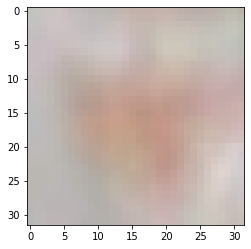

In [12]:
predict_image("Score_0_cells/MultiShoot26_465.jpg")

[[0. 1. 0. 0.]]


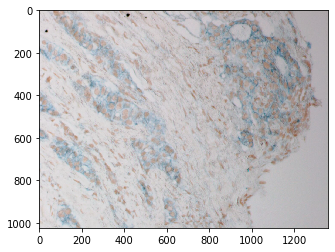

In [13]:
predict_image("score_1/MultiShoot2 (17).jpg")

[[0.0000000e+00 0.0000000e+00 1.0000000e+00 1.1465706e-31]]


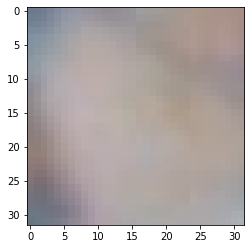

In [14]:
predict_image("score_2_cells/MultiShoot3 (6)_134.jpg")

[[0. 0. 0. 1.]]


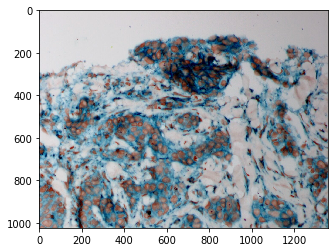

In [15]:
predict_image("score_3/MultiShoot8 (14).jpg")